In [10]:
%%capture
from src.modules.models.tdcnn import TDConvNetpp, WaveformEncoder, WaveformDecoder
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
import soundfile as sf
import librosa
import numpy as np

In [32]:
from torchaudio.compliance.kaldi import fbank

def compute_fbank_features(waveforms):
    fbank_features = [
        fbank(
            waveform.unsqueeze(0),
            htk_compat=True,
            sample_frequency=32_000,
            use_energy=False,
            window_type="hanning",
            num_mel_bins=256,
            dither=0.0,
            frame_shift=10
        )
        for waveform in waveforms
    ]
    return torch.stack(fbank_features)

def pad_to_length(arr, target_length=80000):
    current_length = len(arr)
    if current_length == target_length:
        return arr
    # Calculate padding
    padding_length = target_length - current_length
    padded_array = np.pad(arr, (0, padding_length), 'constant', constant_values=0)
    return padded_array

In [2]:
encoder = WaveformEncoder(256, 256)
decoder = WaveformDecoder(256, 256)
model = TDConvNetpp(in_chan=256, n_src=4, n_repeats=4, encoder=encoder, decoder=decoder)

In [3]:
checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/xcm-normal-epoch059-loss_valid-11.4109-metric_valid11.4107.ckpt"
state_dict = torch.load(checkpoint, weights_only=False)
state_dict = {k[6:]:v for k,v in state_dict["state_dict"].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
encoder = model.encoder
decoder = model.decoder

In [5]:
ds = load_dataset("DBD-research-group/BirdSet", "NBP_scape", cache_dir="data/NBP_scape")

In [22]:
wave, sr = sf.read(ds["test_5s"][1]["filepath"])
wave = librosa.resample(wave, orig_sr=sr, target_sr=16_000)
wave = pad_to_length(wave, 80000)
wave = torch.tensor(wave).unsqueeze(0).float()

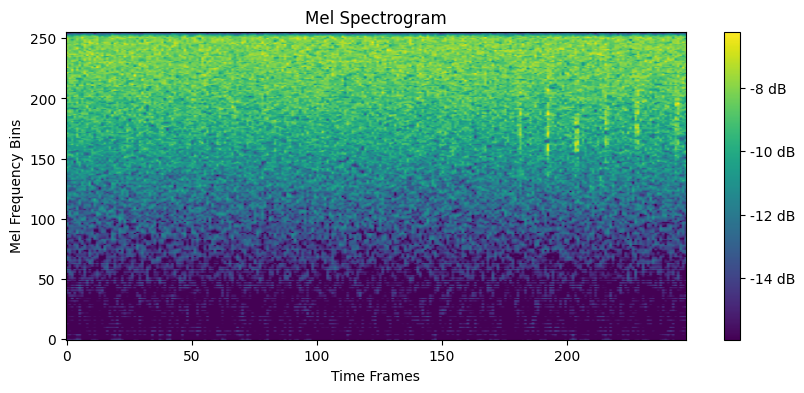

In [33]:
fbank_features = compute_fbank_features(wave)
plt.figure(figsize=(10, 4))
plt.imshow(fbank_features[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.show()

(256, 625)


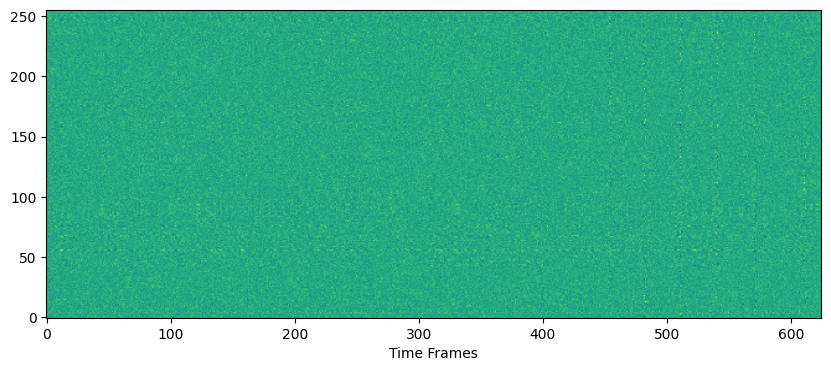

In [31]:
features = encoder(wave).detach().numpy()
print(features.shape)
plt.figure(figsize=(10, 4))
plt.imshow(features, aspect='auto', origin='lower')
#plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time Frames')
plt.show()